In [2]:
import pandas as pd

_dir = '../../data'

df = pd.concat([
 pd.read_csv(f'{_dir}/preprocessed_train.csv'),
 pd.read_csv(f'{_dir}/train_rs.csv'),
 pd.read_csv(f'{_dir}/train_rd.csv'),
])

df = df[['data', 'label']]

df.head()

,data,label
0,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
2,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3
3,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,1
4,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,1


In [3]:
import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = TFBertModel.from_pretrained("klue/bert-base", from_pt=True)

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [4]:
from tqdm.notebook import tqdm

def cls_embedding(data):
    for row in tqdm(data):
        inputs = tokenizer(row, return_tensors='tf', truncation=True)
        outputs = model(inputs)
        cls_embeddings = outputs.last_hidden_state[:,0]
        yield cls_embeddings 

In [5]:
import numpy as np

cls_emb = list(cls_embedding(df['data']))
emb_df = pd.DataFrame(np.squeeze(np.array(cls_emb), axis=1))

  0%|          | 0/11850 [00:00<?, ?it/s]

In [6]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.359317,-0.702831,-0.573080,0.684754,0.872938,0.309491,-0.480664,-0.197872,1.640637,-0.002314,...,0.035559,0.188397,-0.267862,-0.499227,0.189266,-0.753793,-0.206783,0.224637,-0.893487,0.136315
1,0.252396,-0.500247,-0.235553,-0.096403,0.320728,0.121425,-0.928532,0.686953,1.755515,0.618956,...,0.075407,-0.232331,-0.185619,0.276091,0.643697,-0.530379,-0.048291,0.324600,-0.230801,-0.226705
2,0.742206,-0.325070,-0.157420,1.286074,1.075361,0.189326,0.218960,0.153680,0.876944,-0.116227,...,-0.435012,0.175070,-0.094890,-0.973075,0.185539,-1.071784,-0.784394,0.839996,0.064411,-0.031872
3,0.513824,-0.646715,-0.449980,-0.245871,0.474216,-0.110154,1.034201,0.531661,0.929768,-0.566891,...,-0.492184,-0.069331,0.035267,-0.494979,-0.401697,-0.071955,0.086595,0.449325,-0.680995,0.276713
4,0.882560,0.017074,-1.146711,0.265954,0.453349,-1.211668,-0.348621,-0.414122,1.348409,0.325772,...,0.549425,0.689190,-0.720665,-1.176891,-0.348082,-0.410114,0.127535,0.994096,-0.624409,0.247154


In [19]:
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

class ClassifierModel():
    def __init__(self):
        super(ClassifierModel, self).__init__()
        
        self.model = self.CNN()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
            
    def CNN(self):
    
        inputs = Input(shape=(None, 768))
#         embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(inputs)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
        
    
    def summary(self):
        return self.model.summary()
    
    
    def train(self, x, y, x_val, y_val):
        self.history = self.model.fit(
            x, y, epochs=20, batch_size=64,
            validation_data=(x_val, y_val), callbacks=self.es, verbose=1)
    
    def evaluate(self, x, y):
        return self.model.evaluate(x, y, verbose=2)
    
    
    def show_history(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title(f'accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title(f'loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
    
    def show_report(self, x, y):
        y_pred = self.model.predict(x).argmax(axis=1)
        y_true = y.argmax(axis=1)
                
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

Y = tf.keras.utils.to_categorical(df['label'], num_classes=4, dtype='float32')

x_train, x_val, y_train, y_val = train_test_split(emb_df, Y, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [20]:
model = ClassifierModel()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 768)]  0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 64)     147520      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, None, 64)     147520      input_3[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 64)           0           conv1d_3[0][0]                   
____________________________________________________________________________________________

In [21]:
model.train(x_train, y_train, x_val, y_val)

Epoch 1/20


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv1d_4 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 768)


In [128]:
model.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.4844 - accuracy: 0.8481


[0.48442333936691284, 0.8481012582778931]

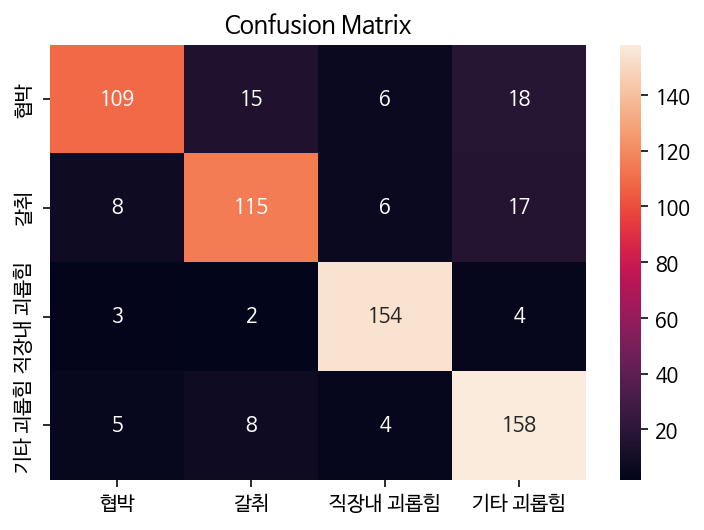

In [129]:
model.show_report(x_test, y_test)